# Imdb - PProductions

----


# Topicos
1. Introdução
2. Carregamento e tratamento dos dados
    - 2.1 Importação das bibliotecas
    - 2.2 Leitura do dataset
    - 2.3 Tratando as colunas *Unnamed:0* e *Runtime*
    - 2.4 Tratando a coluna *Certificate*
    - 2.5 Tratando a coluna *Gross*
    - Ajustes de tipos de dados e formatações.
3. Analise Exploratória (EDA)
    - 3.1 Qual genero tem o maior IMDB_Rating?
    - 3.2 Quantos representantes de cada genero temos nos nossos dados?
    - 3.3 Quais variáveis tem maior correlação com o Gross?
    - 3.4 Qual a média de faturamento por genero?
    - 3.5 Qual diretor possuí maior média de faturamento?
    - 3.6 Quais são as combinações de palavras mais frequentes na coluna Overview?
4. Machine Learning / Modelagem
    - 4.1 É possível inferir o genero do titulo através da coluna Overview?
    - 4.2 Criando modelo de Regressão para prever o IMDB_Rating
---

# 1 - Introdução

A indústria cinematográfica é um mercado de alto risco e grande investimento. Para um estúdio como a **PProductions**, a escolha do próximo filme a ser produzido é uma decisão estratégica que pode definir o sucesso financeiro do ano. Este projeto tem como objetivo principal mitigar esse risco, utilizando a **ciência de dados** para transformar informações históricas em **insights** acionáveis e responder à pergunta central: *"Qual tipo de filme a PProductions deve desenvolver para maximizar suas chances de sucesso?*". Para isso, foi realizada uma análise detalhada sobre um rico dataset do **IMDb**, explorando as relações entre gênero, elenco, diretores, faturamento e as notas da crítica e do público para fornecer recomendações baseadas em evidências.

----

# 2 - Carregamento e tratamento dos dados

## 2.1 - Importando as bibliotecas

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import matplotlib.ticker as ticker
import joblib

from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

pd.set_option('display.float_format', '{:,.2f}'.format)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jbmor_cyx2d7v\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
def formatar_faturamento(valor):

    if pd.isnull(valor):
        return "N/A"

    valor = float(valor)

    if valor >= 1_000_000_000:
        # Converte para Bilhões
        return f'${valor / 1_000_000_000:.1f} B'
    elif valor >= 1_000_000:
        # Converte para Milhões
        return f'${valor / 1_000_000:.1f} M'
    elif valor >= 1_000:
        # Converte para Milhares (caso precise)
        return f'${valor / 1_000:.1f} K'
    else:
        return f'${valor:.0f}'

## 2.2 - Leitura do Dataset

In [34]:
caminho = "https://raw.githubusercontent.com/JosueMorfim/indicium-pproductions/refs/heads/main/desafio_indicium_imdb.csv"

# Carregando os dados em um DataFrame
imdb = pd.read_csv(caminho)

# Visualizando as 5 primeiras linhas
imdb.head()

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.20,An organized crime dynasty's aging patriarch t...,100.00,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.00,When the menace known as the Joker wreaks havo...,84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.00,The early life and career of Vito Corleone in ...,90.00,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.00,A jury holdout attempts to prevent a miscarria...,96.00,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.90,Gandalf and Aragorn lead the World of Men agai...,94.00,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


## 2.3 - Tratando as colunas *Unnamed:0* e *Runtime*

* **Unnamed:0** : É o rank do site IMDB, vou remover esta coluna pois não vai agregar em nosso projeto.
* **Runtime** : Os valores desta coluna estão como string "175 min". Vou criar uma nova coluna "Runtime_min" e manter apenas os dados numericos da coluna Runtime.

In [35]:
# Removendo a coluna Unnamed:0
imdb.drop('Unnamed: 0', axis=1, inplace=True)

# Criando a coluna "Runtime_min" contendo apenas os valores numericos da coluna "Runtime"
imdb['Runtime_min'] = imdb['Runtime'].apply(lambda x: x.split(' ')[0]).astype(int)

# Removendo a coluna Runtime
imdb.drop('Runtime', axis=1, inplace=True)

Verificando os tipos de dados, contagem de nulos, quantidade de linhas.

In [36]:
print('Quantidade de variaveis duplicadas é',imdb.duplicated().sum())

Quantidade de variaveis duplicadas é 0


In [37]:
# Visualizando as informações do DataFrame
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    object 
 2   Certificate    898 non-null    object 
 3   Genre          999 non-null    object 
 4   IMDB_Rating    999 non-null    float64
 5   Overview       999 non-null    object 
 6   Meta_score     842 non-null    float64
 7   Director       999 non-null    object 
 8   Star1          999 non-null    object 
 9   Star2          999 non-null    object 
 10  Star3          999 non-null    object 
 11  Star4          999 non-null    object 
 12  No_of_Votes    999 non-null    int64  
 13  Gross          830 non-null    object 
 14  Runtime_min    999 non-null    int64  
dtypes: float64(2), int64(2), object(11)
memory usage: 117.2+ KB


In [38]:
# Contagem de dados nulos por coluna
imdb.isnull().sum()

Series_Title       0
Released_Year      0
Certificate      101
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
Runtime_min        0
dtype: int64

In [39]:
print(f'Porcentagem de dados faltantes na coluna Certificate : {round(imdb.Certificate.isnull().sum() / len(imdb) * 100,2)}%')
print(f'Porcentagem de dados faltantes na coluna Meta_score : {round(imdb.Meta_score.isnull().sum() / len(imdb) * 100,2)}%')
print(f'Porcentagem de dados faltantes na coluna Gross : {round(imdb.Gross.isnull().sum() / len(imdb) * 100,2)}%')

Porcentagem de dados faltantes na coluna Certificate : 10.11%
Porcentagem de dados faltantes na coluna Meta_score : 15.72%
Porcentagem de dados faltantes na coluna Gross : 16.92%


## 2.4 - Tratando a coluna Certificate

  * Esta coluna faz referencia a ***Classificação etária*** do titulo. Como não podemos advinhar qual a classificação correta, vamos apenas substituir os valores nulos por "**Unknown**"

In [40]:
# Preenchendo os valores nulos da coluna "Certificate" com a categoria "Unknown"
imdb['Certificate'] = imdb['Certificate'].fillna("Unknown")

#Verificando quantos valores nulos restaram
print('Quantidade de nulos na coluna Certificate:', imdb.Certificate.isnull().sum())

Quantidade de nulos na coluna Certificate: 0


## 2.5 - Tratando a coluna Meta_score.

  * Vai ser feito o preenchimento dos valores nulos da coluna **Meta_score** com a *mediana* de **Meta_score** por **Genre**. Para isto vamos realizar os seguintes passos:
      1. Como a coluna **Genre** tem mais de uma categoria por linha, vou criar uma nova coluna chama "**main_genre**" apenas com a primeira categoria da coluna **Genre**.
      2. Substituír os valores nulos pela mediana de **Mesta_score** agrupado pela coluna **main_genre**.
      

In [41]:
# Verificando quantidade de combinações unicas de generos
print('Quantidade de combinações unicas na coluna Genre:',imdb.Genre.nunique())

# Criando a coluna "main_genre", apenas com o primeiro genero da coluna "Genre"
imdb['main_genre'] = imdb['Genre'].apply(lambda x: x.split(',')[0])

# Quantidade final de gerenos na coluna "main_genre"
print('Quantidade de generos na coluna main_genre:',imdb.main_genre.nunique())

Quantidade de combinações unicas na coluna Genre: 202
Quantidade de generos na coluna main_genre: 14


In [42]:
# Substituíndo os valores Nulos da coluna Meta_score pela Mediana agrupada pela coluna main_genre
imdb['Meta_score'] = imdb['Meta_score'].fillna(imdb.groupby('main_genre')['Meta_score'].transform('median'))
print('Quantidade de nulos na coluna Meta_score:',imdb['Meta_score'].isnull().sum())

Quantidade de nulos na coluna Meta_score: 2


In [43]:
# Removendo os dois nulos faltantes
imdb = imdb.dropna(subset=['Meta_score'])

print('Quantidade de nulos na coluna Meta_score:',imdb['Meta_score'].isnull().sum())

Quantidade de nulos na coluna Meta_score: 0


## 2.6 - Tratando a coluna Gross

> Procurei rapidamente alguns titulos em que a coluna Gross está com dados nulos e percebi que nosso dataset apesar de ter titulos com produções internacionais, esta considerando apenas o valor de faturamento doméstico (USA/Canadá).

* Vamos substituír os dados nulos da coluna **Gross** pela mediana da coluna **Gross** agrupado por ***década/genero***. Para isto vamos:
    1. Formatar os type das colunas **Released_Year** e **Gross** para númerico.
    2. Criar a coluna "**decade**", com a década de lançamento de cada titulo.
    3. Fazer o preenchimento dos dados nulos da coluna **Gross** pela mediana agrupada pelas colunas **decade** e **main_genre**.

In [44]:
# Analisando o conteudo da coluna "Released_Year"
print(imdb.Released_Year.unique())

['1972' '2008' '1974' '1957' '2003' '1994' '1993' '2010' '1999' '2001'
 '1966' '2002' '1990' '1980' '1975' '2020' '2019' '2014' '1998' '1997'
 '1995' '1991' '1977' '1962' '1954' '1946' '2011' '2006' '2000' '1988'
 '1985' '1968' '1960' '1942' '1936' '1931' '2018' '2017' '2016' '2012'
 '2009' '2007' '1984' '1981' '1979' '1971' '1963' '1964' '1950' '1940'
 '2013' '2005' '2004' '1992' '1987' '1986' '1983' '1976' '1973' '1965'
 '1959' '1958' '1952' '1948' '1944' '1941' '1927' '1921' '2015' '1996'
 '1989' '1978' '1961' '1955' '1953' '1925' '1924' '1982' '1967' '1951'
 '1949' '1939' '1937' '1934' '1928' '1926' '1970' '1969' '1956' '1947'
 '1945' '1930' '1938' '1935' '1933' '1932' '1943' 'PG']


> Há um valor "**PG**" no meio dos anos de lançamento. Vou forçar todos os valores para númericos, e os que forem **PG**, vão virar **Nulos** e então trataremos deles.

In [45]:
# Convertendo a coluna Released_Year para numeric
imdb['Released_Year'] = pd.to_numeric(imdb['Released_Year'], errors='coerce')

# Visualizando titulos com Released_Year nulo
imdb[imdb['Released_Year'].isnull()][['Series_Title','Director','Star1']]

,Series_Title,Director,Star1
965,Apollo 13,Ron Howard,Tom Hanks


> Como é apenas 1 filme que está faltando a data, busquei no IMDB [Link](https://www.imdb.com/title/tt0112384/?ref_=fn_ttl_ttl_1) e vi que o ano de lançamento foi 1995. Vou apenas preencher com a informação correta.

* Já vou mudar o tipo da coluna Gross e Released_Year para númerico.

In [46]:
# Substutuíndo o valor nulo da coluna Released_Year pelo dado correto.
imdb['Released_Year'] = imdb['Released_Year'].fillna(1995)

# Removendo as "," da coluna Gross.
imdb['Gross'] = imdb['Gross'].str.replace(',','', regex=True)

# Convertendo a coluna gross para numerico.
print('Nulos antes da conversão:',imdb['Gross'].isnull().sum())
imdb['Gross'] = pd.to_numeric(imdb['Gross'], errors='coerce')
print('Nulos após da conversão:',imdb['Gross'].isnull().sum())

Nulos antes da conversão: 167
Nulos após da conversão: 167


> Criando a coluna **decade**.

In [47]:
# Criar faixas de 10 em 10 anos
imdb['decade'] = (imdb['Released_Year'] // 10 * 10).astype('Int64')

print('Quantidade de nulos na coluna decade:',imdb['decade'].isnull().sum())

Quantidade de nulos na coluna decade: 0


> Substituíndo valores **nulos** pela mediana agrupada pelas colunas **decade** e **main_genre**

In [48]:
# Substituíndo valores nulos pela mediana agrupada pelas colunas decade e main_genre
imdb['Gross'] = imdb['Gross'].fillna(imdb.groupby(['decade','main_genre'])['Gross'].transform('median'))

print('Quantidade de nulos na coluna Gross:',imdb['Gross'].isnull().sum())

Quantidade de nulos na coluna Gross: 12


* Restaram 12 titulos com nulos na coluna Gross. Vamos ver quais são esses titulos.

In [49]:
# Exibindo titulos com valores de Gross nulos
imdb[imdb['Gross'].isnull()][['Series_Title','decade','Gross','main_genre']]

,Series_Title,decade,Gross,main_genre
17,Hamilton,2020,NaN,Biography
19,Soorarai Pottru,2020,NaN,Drama
204,Soul,2020,NaN,Animation
307,White Heat,1940,NaN,Action
463,Dil Bechara,2020,NaN,Comedy
611,The Trial of the Chicago 7,2020,NaN,Drama
612,Druk,2020,NaN,Comedy
708,Red River,1940,NaN,Action
709,Key Largo,1940,NaN,Action
713,The Lady Vanishes,1930,NaN,Mystery


In [50]:
# Exibindo quantos valores pode Década
imdb.decade.value_counts()

decade
2010    242
2000    237
1990    150
1980     89
1970     76
1960     73
1950     56
1940     35
1930     24
1920      9
2020      6
Name: count, dtype: Int64

* Apesar de todos os titulos da década de **2020** estarem com **Gross** nulos, vou fazer a remoção de todos os 12 valores nulos.

In [51]:
# Removendo valores nulos da coluna Gross
imdb = imdb.dropna(subset=['Gross'])

print('Quantidade de nulos no dataset:', imdb.isnull().sum().sum())

print('Quantidade de linhas do dataset:',imdb.shape[0])

print('Quantidade de linhas duplicadas no dataset:',imdb.duplicated().sum())


Quantidade de nulos no dataset: 0
Quantidade de linhas do dataset: 985
Quantidade de linhas duplicadas no dataset: 0


In [52]:
print(imdb.dtypes.reset_index().rename(columns={"index": "Coluna", 0: "Tipo"}))


           Coluna     Tipo
0    Series_Title   object
1   Released_Year  float64
2     Certificate   object
3           Genre   object
4     IMDB_Rating  float64
5        Overview   object
6      Meta_score  float64
7        Director   object
8           Star1   object
9           Star2   object
10          Star3   object
11          Star4   object
12    No_of_Votes    int64
13          Gross  float64
14    Runtime_min    int64
15     main_genre   object
16         decade    Int64


# 3. Analise exploratória (EDA)



## 3.1 Qual genero tem o maior IMDB_Rating?

C:\Users\jbmor_cyx2d7v\AppData\Local\Temp\ipykernel_17136\4219526651.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_gross.values, y=genre_gross.index, palette='viridis')


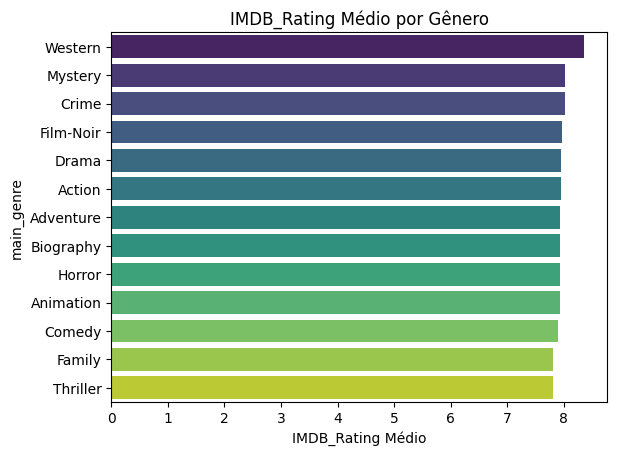

In [53]:
# Grafico de barras IMDB_Rating x main_genre
genre_gross = imdb.groupby('main_genre')['IMDB_Rating'].mean().sort_values(ascending=False)
sns.barplot(x=genre_gross.values, y=genre_gross.index, palette='viridis')
plt.title('IMDB_Rating Médio por Gênero')
plt.xlabel('IMDB_Rating Médio')
plt.show()

* O gerenro **Western** se destaca com a melhor média .

## 3.2 Quantos representantes de cada genero temos nos nossos dados?

C:\Users\jbmor_cyx2d7v\AppData\Local\Temp\ipykernel_17136\1088669469.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


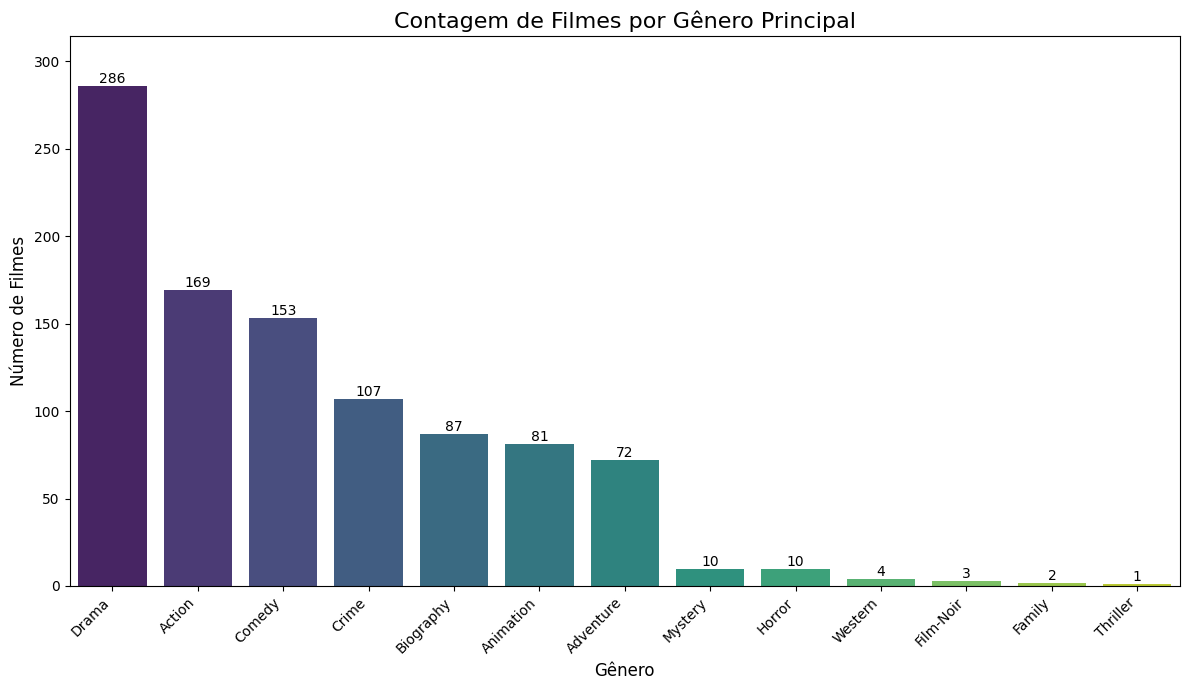

In [54]:
# Grafico de barras contagem de filmes por genero
genre_counts = imdb['main_genre'].value_counts()

plt.figure(figsize=(12, 7))
ax = sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')

for bar in ax.patches:
    ax.text(
        x=bar.get_x() + bar.get_width() / 2,
        y=bar.get_height(),
        s=f'{int(bar.get_height())}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('Contagem de Filmes por Gênero Principal', fontsize=16)
plt.xlabel('Gênero', fontsize=12)
plt.ylabel('Número de Filmes', fontsize=12)
plt.xticks(rotation=45, ha='right')
ax.set_ylim(0, genre_counts.max() * 1.1)

plt.tight_layout()
plt.show()

* O genero **Western** tem apenas 4 representantes e a maior média no **IMDB_Rating**, será que essa performance permaneceria se houvesse mais representantes?
* O genero **Drama** tem 286 representantes e a quinta maior média no **IMDB_Rating**

## 3.3 Quais variáveis tem maior correlação com o Gross?

Correlação das variáveis com a Nota do IMDB:
Gross            1.00
No_of_Votes      0.59
Released_Year    0.27
decade           0.27
Runtime_min      0.15
IMDB_Rating      0.09
Meta_score      -0.07
Name: Gross, dtype: float64


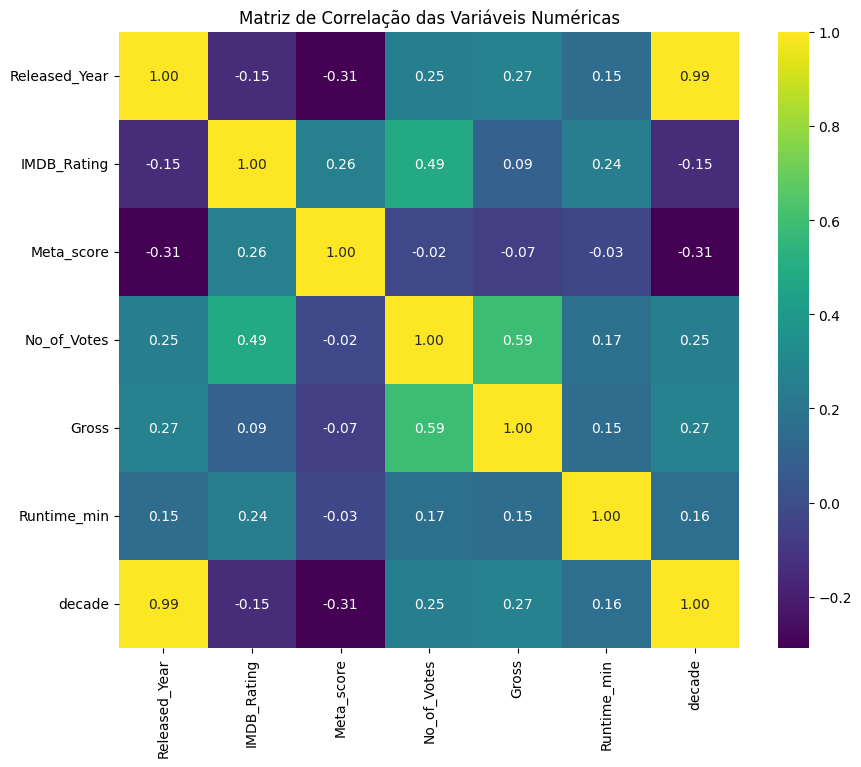

In [55]:
# Matriz de correlação
numeric_cols = imdb.select_dtypes(include=np.number)
correlation_matrix = numeric_cols.corr()
imdb_rating_corr = correlation_matrix['Gross'].sort_values(ascending=False)

print("Correlação das variáveis com a Nota do IMDB:")
print(imdb_rating_corr)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Matriz de Correlação das Variáveis Numéricas')
plt.show()

* **decade** tema maior correlação com o faturamento e isto é facilmente explicado pela globalização do acesso e o aumento populacional.
* **No_of_Votes** tem a segunda maior correlação. Pois o número de pessoas que votaram está diretamente ligado ao número de pessoas que pagaram para assistir o titulo.
* **Meta_score** Tem a menor correlação com o faturamento. A crítica de especialistas parece não ter muita influencia na população geral.

## 3.4 Qual a média de faturamento por genero?

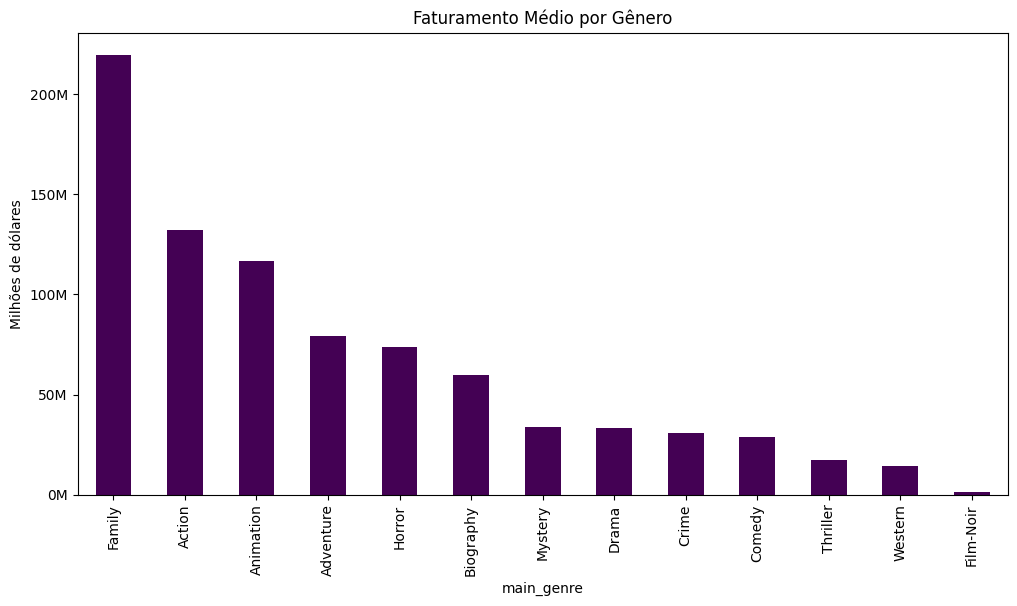

In [56]:
faturamento_por_genero = imdb.groupby('main_genre')['Gross'].mean().sort_values(ascending=False)

ax = faturamento_por_genero.plot(
    kind='bar',
    figsize=(12,6),cmap='viridis',
    title='Faturamento Médio por Gênero'
)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))

plt.ylabel("Milhões de dólares")
plt.show()


* O genero Family possui o maior faturamento médio, acima de R$ 200 milhões.
* O genero Western que perfoma em primeiro na média do Imdb_Rating, esta em penultimo no ranking de faturamento.

## 3.5 Qual diretor possuí maior média de faturamento?

In [57]:
faturamento_por_diretor = imdb.groupby('Director').agg(
    media_faturamento=('Gross', 'mean'),
    qtd_filmes=('Gross', 'count')
).sort_values(by='media_faturamento', ascending=False)

faturamento_por_diretor['media_faturamento'] = faturamento_por_diretor['media_faturamento'].apply(formatar_faturamento)

print(faturamento_por_diretor.head(10))

               media_faturamento  qtd_filmes
Director                                    
Anthony Russo           $551.3 M           4
Gareth Edwards          $532.2 M           1
J.J. Abrams             $474.4 M           3
Josh Cooley             $434.0 M           1
Roger Allers            $422.8 M           1
Tim Miller              $363.1 M           1
James Gunn              $361.5 M           2
James Cameron           $349.6 M           5
Byron Howard            $341.3 M           1
David Yates             $326.3 M           3


* Diretores como Anthony Russo (com 4 filmes) e J.J. Abrams (com 3 filmes) aparecem com faturamento médio muito alto, o que indica que conseguiram manter o sucesso em mais de uma produção. Isso mostra que não foi apenas sorte de um único filme, mas sim consistência.

## 3.6 Quais são as combinações de palavras mais frequentes na coluna Overview?

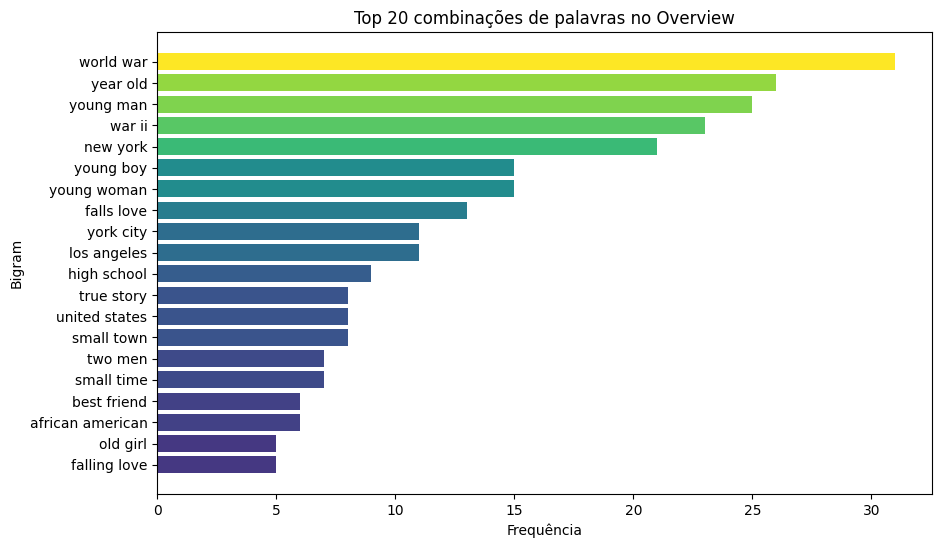

In [58]:
# Palavras da coluna Overview que aparecem juntas mais vezes
stop_words = set(stopwords.words('english'))
vec = CountVectorizer(ngram_range=(2, 2), stop_words=list(stop_words)).fit(imdb['Overview'])
bag_of_words = vec.transform(imdb['Overview'])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

# Criando DataFrame para a visualização
df_bigrams = pd.DataFrame(words_freq[:20], columns=['Bigram', 'Frequência'])

# Grafico de barras
plt.figure(figsize=(10,6))
plt.barh(
    df_bigrams['Bigram'][::-1],
    df_bigrams['Frequência'][::-1],
    color=plt.cm.viridis(df_bigrams['Frequência'][::-1] / max(df_bigrams['Frequência']))
)
plt.title("Top 20 combinações de palavras no Overview")
plt.xlabel("Frequência")
plt.ylabel("Bigram")
plt.show()

* A combinação "world war" fico no topo do ranking com cerca de 30 menções.
* Se somarmos todas as combinações que tem a palavra "yong" chegaremos a cerca de 55 menções.

> Com base nas análises feitas, eu recomendaria para uma pessoa que não conheço assistir The Godfather. Ele tem alto número de votos (1620367) oque sugere uma alta popularidade, o genero Crime/Drama tem otimas médias gerais de IMDB_Rating que indica que são generos bem aceitos pela população, além de possuir mais 2 filmes de sucesso como sequencia.

# 4 - Machine Learning / Modelagem

## 4.1 - É possível inferir o genero do titulo através da coluna Overview?

In [59]:
# Configurando o e vetorizando a coluna Overiew
tfidf = TfidfVectorizer(sublinear_tf=True,
                        min_df=5,
                        norm='l2',
                        encoding='latin-1',
                        ngram_range=(1, 2),
                        stop_words=list(stop_words))

features = tfidf.fit_transform(imdb.Overview).toarray()
labels = imdb.main_genre

# Separando os dados entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(features, labels,
                                                    test_size=0.25,
                                                    random_state=42)

# Criando o modelo
model = MultinomialNB()

# Treinando o modelo
model.fit(X_train, y_train)

# Realização a predição
y_pred = model.predict(X_test)

print(f"Acurácia do modelo: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

Acurácia do modelo: 33.20%

Relatório de Classificação:
              precision    recall  f1-score   support

      Action       0.42      0.27      0.33        52
   Adventure       0.00      0.00      0.00        15
   Animation       0.00      0.00      0.00        17
   Biography       0.00      0.00      0.00        19
      Comedy       0.28      0.13      0.18        38
       Crime       0.60      0.11      0.18        28
       Drama       0.31      0.88      0.46        68
      Family       0.00      0.00      0.00         2
      Horror       0.00      0.00      0.00         3
     Mystery       0.00      0.00      0.00         5

    accuracy                           0.33       247
   macro avg       0.16      0.14      0.12       247
weighted avg       0.29      0.33      0.24       247



c:\Users\jbmor_cyx2d7v\Documents\Indicium\Ciencia de dados\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jbmor_cyx2d7v\Documents\Indicium\Ciencia de dados\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jbmor_cyx2d7v\Documents\Indicium\Ciencia de dados\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

* É possível prever o genero do filme através da coluna **Overview**.
* A eficacia do modelo ficou em **33.20%.**
* A baixa eficacia é resultado de um dataset desbalanceado, com muitos representantes do genero Drama, influenciando o algorito a "prever" o genero **Drama** com mais frequencia.

## 4.2 É possível prever o IMDB_Rating de um filme?

* Como queremos prever um valor númerico, vamos usar um modelo de Regressão.
* Algumas informações relevantes que são categóricas vão ser transformadas em númericas para o modelo entender.
* Para calcular o sucesso do modelo, vai ser usado o RMSE. Esta métrica vai nos voltar o erro médio do nosso modelo, quanto mais próximo de 0 o valor de retorno, melhor é o modelo.

In [60]:
# Usaremos variáveis numéricas e categóricas que parecem relevantes.
features = ['Meta_score', 'No_of_Votes', 'Gross', 'Runtime_min', 'main_genre', 'Certificate']
X = imdb[features]
y = imdb['IMDB_Rating']

# Converte colunas de texto como 'main_genre' em formato numérico.
X_encoded = pd.get_dummies(X, columns=['main_genre', 'Certificate'], drop_first=True)

# Divisão em Dados de Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Instanciando e treinando o modelo
model_reg = RandomForestRegressor(n_estimators=50, random_state=42)
model_reg.fit(X_train, y_train)

# Fazendo predições nos dados de teste
y_pred_reg = model_reg.predict(X_test)

# Calculando o RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))
print(f"O RMSE do modelo foi: {rmse:.2f}")


O RMSE do modelo foi: 0.20


* O RMSE do modelo ficou em 0.20, oque podemos considerar um bom modelo.

In [61]:
# Criando o DataFrame com os dados do filme
filme_exemplo = pd.DataFrame([{
    'Meta_score': 80.0,
    'No_of_Votes': 2343110,
    'Gross': 28341469.0,
    'Runtime_min': 142,
    'main_genre': 'Drama',
    'Certificate': 'A'
}])

X_encoded_cols = X_train.columns
filme_exemplo_encoded = pd.get_dummies(filme_exemplo).reindex(columns=X_encoded_cols, fill_value=0)

# Fazendo a previsão
nota_prevista = model_reg.predict(filme_exemplo_encoded)
print(f"A nota prevista para 'The Shawshank Redemption' é: {nota_prevista[0]:.2f}")

A nota prevista para 'The Shawshank Redemption' é: 8.83


* Apesar da nota real do filme '**The Shawshank Redemption**' ser 9.3 e o modelo ter previsto como 8.83, ele previu que com as caracteristicas fornecidas o filme teria uma nota alta.

## 4.3 - Salvando modelo e dependencias

In [62]:
joblib.dump(model_reg, "modelo_imdb.pkl")
joblib.dump(X_encoded.columns, "colunas_treinadas.pkl")
!pip freeze > requirements.txt